<center>

*******************************************************************************************
    
### MEASUREMENT OF RELATIVE MOTION AMONGST MUSICIANS 

### USING DYNAMIC TIME WARPING      

<br>
    
##### 6 AUGUST 2023  

##### Juan Ignacio Mendoza Garay  
##### doctoral student  
##### Department of Music, Art and Culture Studies  
##### University of Jyväskylä  

*******************************************************************************************

</center>

#### INFORMATION:


* Description:

    Demonstrates the application of Dynamic Time Warping to measure anticipation and delay of events         amongst musicians performing together.


* Instructions:

    Edit the values indicated with an arrow like this: <---  
    Comment/uncomment or change values as suggested by the comments.  
    Run the program, close your eyes and hope for the best.  

*******************************************************************************************


In [132]:
import csv
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import interpolate
from scipy.spatial.distance import cdist
from tslearn.metrics import dtw_path
import time

*******************************************************************************************
#### INPUT INFORMATION OF DATA AND PARAMETERS:


In [133]:
# The data used here is marker-based motion capture of string quartet performances.
# The dataset contains other data as well (e.g., video, audio, IMU).
# The authors of he dataset are Esteban Maestre, Panos Papiotis, Marco Marchini and Alfonso Perez.
# More information here: https://www.upf.edu/web/mtg/quartet-dataset

dataset_path = '/Users/me/Documents/UP3E' # <--- path of the dataset folder
results_path = '' # <--- path to save figures (empty = don't save)
fn_prefix = 'C7.Body.' # <--- marker.name (e.g., 'C7.Body' for upper body, 'TFHD.Body' for top forehead)
fn_instr_all = ['Violinist1','Violinist2','Violist','Cellist'] # <--- All instruments to consider
fn_dims = ['_X','_Y','_Z'] # <--- spatial axes to cosnider (e.g., X,Y,Z)

downsample_factor = 9 # <--- downsampling factor (9 results in 49 Hz at sampling rate = 441 Hz)

font_size = 10 # <--- font size for figures

*******************************************************************************************
#### FUNCTIONS:


In [134]:
def load_inst(inst_name):
    
    """ 
    Load data for one instrument. 
    """

    partial_fn = dataset_path + '/' + fn_prefix + inst_name 
    
    for i_dim in range(0,len(fn_dims)):
    
        this_fn = partial_fn + fn_dims[i_dim] + '.csv'
        
        with open(this_fn) as csv_file:
            csv_reader = csv.reader(csv_file)
            c = 0
            for row in csv_reader:
                if c == 1:
                    raw_v = np.array(row)
                c += 1 
       
        this_ds = raw_v[1::downsample_factor]
        
        if i_dim == 0:
            ds_pos = np.empty( (3, this_ds.size ) )
    
        ds_pos[i_dim,:] = this_ds
    
    return ds_pos

In [135]:
def sqnorm_diff(pos):

    """ 
    Euclidean distance between successive points in a time-series 
    """
    
    diff_v = np.empty( pos.shape[1] )
    
    for i_time in range(1,pos.shape[1]):

        diff_v[i_time] =  math.dist( pos[:,i_time] , pos[:,i_time-1] )
    
    diff_v[0] = diff_v[1]/2

    return diff_v

In [136]:
plt.rcParams.update({'font.size':font_size})

def plot_ts(y,y_label='',title='',labels='',file_name=''):
    
    """ 
    Make a beautiful plot.
    
    INPUT:
    
    y : time-series.
    y_label : label for time-series data
    title : title of the figure
    data_labels : labels for time-series data in row order
    file_name : file name without extension (empty = don't save)
    
    """
    
    plt.plot( np.arange(0,y.shape[y.ndim-1],1) ,y.T )
    plt.xlabel('time (samples)')
    plt.ylabel(y_label)
    plt.title(title)
    if labels:
        plt.legend(labels)
    if file_name:
        plt.savefig(file_name+'.png', bbox_inches='tight')

In [137]:
def mean_cdist(all_ts,i_one,i_others):
    
    """
    Mean distance matrix between one time series and one or more time series of the same length.

    INPUT:
    all_ts : time series, each in a row (array)
    i_one : index of one time series (int)
    i_other : index (int) or indices (list) of the other time series 

    OUTPUT:
    mean_dm : mean distance matrix (array)
    """

    if type(i_others) is int:
        i_others = [i_others]
    
    sum_dm = np.zeros( (all_ts.shape[1],all_ts.shape[1]) )

    data_one = all_ts[i_inst,:].reshape(-1,1)

    for i_other in i_others:

        data_other = all_ts[i_other,:].reshape(-1,1)

        sum_dm = sum_dm + cdist( data_one , data_other , 'cityblock')

    mean_dm = sum_dm / len([i_others])
    
    return mean_dm

In [138]:
def dtw(dm):
    
    """
    Dynamic Time Warping.

    INPUT:
    dm : distance matrix (array)

    OUTPUT:
    C : cumulative DTW cost matrix (array)
    dtw_score : minium cost (scalar)
    """

    # initialisation:
    C = np.empty((dm.shape[0]+1,dm.shape[1]+1))
    C[:] = np.inf
    C[0,0] = 0

    # main loop:
    for i in range(1,C.shape[0]):
        for j in range(1,C.shape[1]):
            C[i,j] = dm[i-1,j-1] + min(C[i-1, j], C[i, j-1], C[i-1, j-1]) # goes barebones
            # C[i,j] = dm[i-1,j-1]**2 + min(C[i-1, j], C[i, j-1], C[i-1, j-1]) # gets cocky

    dtw_score = C[i,j] # barebones
    #dtw_score = np.sqrt(C[i,j]) # cocky

    return C, dtw_score

In [139]:
def tb_dtw(C,method=0):
    
    """
    Traceback of DTW optimal path.
    
    INPUT:
    C : cumulative DTW cost matrix (array)
    method : 0 = 'classical' (default), 1 = 'minimum warp' (int)

    OUTPUT:
    optimal_path (list)
    """

    i, j = np.array(C.shape)-2
    optimal_path = [[i,j]]
    
    while (i > 0) or (j > 0):

        this_query = (C[i, j], C[i, j + 1], C[i + 1, j])

        if method == 0: # classical
            
            this_argmin = np.argmin(this_query)
            
            if this_argmin == 0:
                
                i -= 1
                j -= 1
                
            elif this_argmin == 1:
                
                i -= 1
                
            else:  # this_argmin == 2
                
                j -= 1
            
        else: # minimum warp
            
            this_min = np.min(this_query)
            these_argmins = np.where(this_query==this_min)
            
            if these_argmins[0][0] == 0:
        
                if (np.any(these_argmins[0][:] == 1)) and (i > j):

                    i -= 1

                elif (np.any(these_argmins[0][:] == 2)) and (j > i):

                    j -= 1

                else:

                    i -= 1
                    j -= 1

            elif these_argmins[0][0] == 1:

                i -= 1

            elif these_argmins[0][0] == 2:
                
                j -= 1

        optimal_path.append([i,j])
    
    return optimal_path

In [140]:
def warps_dtw(dm,optimal_path):
    
    """
    Pointwise warp of DTW optimal path:
    
    INPUT:
    dm : distance matrix (array)
    optimal_path : DTW optimal path (list)

    OUTPUT:
    warps : pointwise warp (array)
    """

    pm = np.zeros( dm.shape )
    
    for i_op in range(0,len(optimal_path)):
        pm[optimal_path[i_op][0],optimal_path[i_op][1]] = 1     

    pm_r = np.fliplr(pm).T # rotate to get anti-diagonals (warp domain)
    warps = np.zeros(pm_r.shape[0])
    i_warps = 0
    i_adiag = -pm_r.shape[0] + 1
    step = 2

    while i_adiag <= pm_r.shape[0]: # iterate through anti-adiagonals

        this_adiag = pm_r.diagonal(i_adiag)

        if any(this_adiag):

            i_center = int( np.floor(this_adiag.size / 2) )

            if not this_adiag[int(i_center)] : # value where the anti-adiagonal intersects the main adiagonal

                i_match = int(np.where(this_adiag)[0]) # where the path intersects this anti-diagonal
                
                warps[i_warps] = i_center - i_match

            i_adiag += step
            step = 2
            i_warps += 1
            
        else: # see if there's anything in the next diagonal

            i_adiag += 1
            step = 1
    
    return warps

In [141]:
def novelty(dm,kernel_size,kernel_sd,pos=1):
    
    """

    INPUT:
    dm : distance matrix (array)
    kernel_size : kernel size (int)
    kernel_sd : kernel's gaussian taper standard deviation
    pos : 1 = return only positive values (default), 0 = return all values

    OUTPUT:
    novelty_score: rate of novelty (array)
    """

    if kernel_size%2 != 0 :
        kernel_size += 1
        
    kernel_size_half = int(kernel_size/2)

    xx = np.linspace(-kernel_size_half,kernel_size_half,kernel_size)
    yy = np.linspace(-kernel_size_half,kernel_size_half,kernel_size)
    xx, yy = np.meshgrid(xx, yy)

    gauss_2D = 1. / (2. * np.pi * kernel_sd**2) * np.exp(-(xx**2. / (2. * kernel_sd**2.) + yy**2. / (2. * kernel_sd**2.)))

    kron_cb = np.kron( [[-1,1],[1,-1]] , np.ones( (kernel_size_half,kernel_size_half) ) )

    gausscb_kernel = gauss_2D * kron_cb

    novelty_score = np.empty( dm.shape[0] ) # initialise novelty vector
    novelty_score.fill(np.nan)

    for i_start in np.arange(0,dm.shape[0]-kernel_size):
        i_end = i_start + kernel_size
        novelty_score[ i_start + kernel_size_half ] = np.sum( gausscb_kernel * dm[ i_start:i_end , i_start:i_end ] )

        if pos and ( novelty_score[ i_start + kernel_size_half ] ) < 0 :
            novelty_score[ i_start + kernel_size_half ] = 0

    return novelty_score

*******************************************************************************************
#### LOAD, INSPECT AND PREPROCESS DATA:
[//]: # "foo"

In [142]:
# Load raw position data for each instrument:

for i_inst in range(0,len(fn_instr_all)) :

    ds_pos = load_inst( fn_instr_all[i_inst] )

    if i_inst == 0 :

        pos_all_raw = np.empty((len(fn_dims),ds_pos.shape[1],len(fn_instr_all)))

    pos_all_raw[:,:,i_inst] = ds_pos # [ axis , time , instrument ]

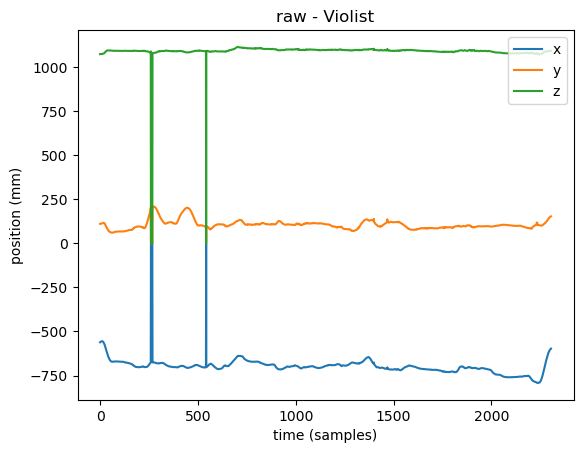

In [143]:
# Plot raw position data:

i_inst = 2 # <--- select instrument

plot_ts( pos_all_raw[:,:,i_inst],'position (mm)','raw - '+fn_instr_all[i_inst],['x','y','z'])

In [144]:
# Fill gaps in data:

pos_all_filled = pos_all_raw.copy()
x = np.arange(0,pos_all_filled.shape[1])

for i_inst in range(0,len(fn_instr_all)) :
    
    for i_dim in range(0,pos_all_filled.shape[0]):

        ivb_zeros = pos_all_filled[i_dim,:,i_inst] == 0
        
        if any(ivb_zeros):
        
            iv_zeros = np.where( ivb_zeros )
            x_nonzero = np.delete(x,iv_zeros)
            y_nonzero = np.delete(pos_all_filled[i_dim,:,i_inst],iv_zeros)
            y_interp =  interpolate.interp1d(x_nonzero, y_nonzero,bounds_error=False, kind='cubic')
            pos_all_filled[i_dim,:,i_inst] = y_interp(x)    

In [145]:
# Remove high frequency noise with a moving average filter:

filter_size = 49 # <--- filter size (0 = don't filter)

hfs = math.floor(filter_size/2)
dfs = filter_size * 2 - 2

if filter_size:
    
    pos_all_smooth = pos_all_filled.copy()

    for i_inst in range(0,len(fn_instr_all)) :
    
        for i_dim in range(0,pos_all_smooth.shape[0]):
            
            this_padded_v = np.empty( (pos_all_smooth.shape[1] +  dfs) ) # nan pad
            this_padded_v[:] = np.nan
            this_padded_v[filter_size-1:this_padded_v.size-filter_size+1] = pos_all_smooth[i_dim,:,i_inst]
            this_smooth_v = np.zeros( pos_all_smooth.shape[1] )
            
            for i_time in range(0,this_smooth_v.size):
                
                this_window = this_padded_v[i_time:i_time+filter_size] 
                
                if i_time < (filter_size-1):
                
                    this_divisor = filter_size - np.isnan(this_window).sum()
                    
                else:
                    this_divisor = filter_size

                this_smooth_v[i_time] = np.nansum(this_window) / this_divisor
                
            
            pos_all_smooth[i_dim,:,i_inst] = this_smooth_v
else:
    
    pos_all_smooth = pos_all_filled


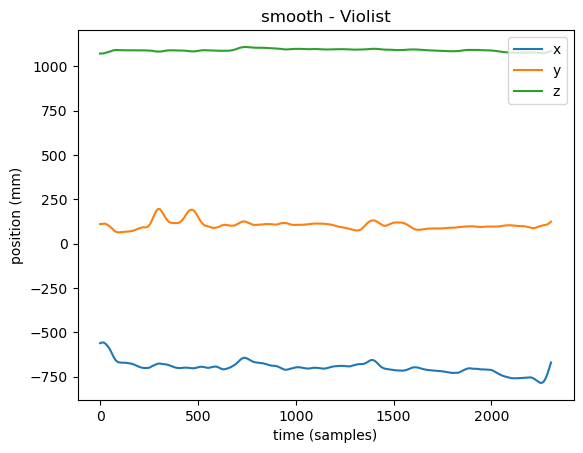

In [146]:
# Plot gap-filled and noise-filtered data:

i_inst = 2 # <--- select instrument

plot_ts( pos_all_smooth[:,:,i_inst],'position (mm)','smooth - '+fn_instr_all[i_inst],['x','y','z'])

In [147]:
# Compute absolute velocity (distance travelled per sample):

spd_all = np.empty( (pos_all_smooth.shape[2],pos_all_smooth.shape[1]) ) # [instrument,time]

for i_inst in range(0,len(fn_instr_all)) :
    
    spd_all[i_inst,:] = sqnorm_diff(pos_all_smooth[:,:,i_inst])   

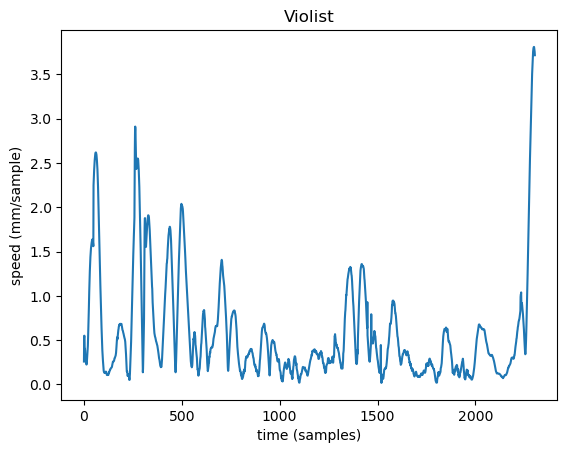

In [148]:
# Plot absolute velocity:

i_inst = 2 # <--- select instrument

plot_ts( spd_all[i_inst,:],'speed (mm/sample)',fn_instr_all[i_inst])

*******************************************************************************************
#### ALIGNMENT OF ONE MUSICIAN VS. OTHER(S), FOR A TIME SELECTION:
[//]: # "foo"

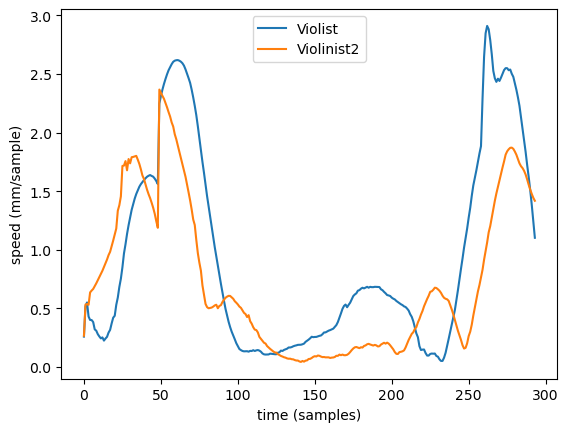

In [149]:
# Plot absolute velocity of a section, for one or more instruments:

sel_inst = [2,1] # <--- select instrument(s)
i_min = 0        # <--- section start
i_max = 49*6     # <--- section end
# i_max = spd_all.shape[1] # end of timeseries

if results_path:
    this_filename = results_path+'/1'
else:
    this_filename = ''
plot_ts(spd_all[sel_inst,i_min:i_max],'speed (mm/sample)','',[fn_instr_all[i] for i in sel_inst],\
        this_filename)

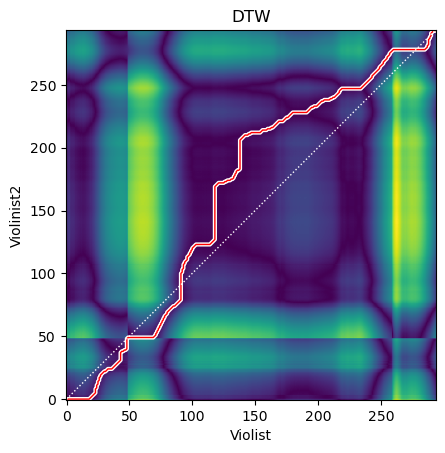

In [150]:
# Compute end visualise DTW path between selected instrument and one or more other instruments:

i_inst = 2   # <--- select one instrument
i_others = 1 # <--- select one or more instrument(s)
#i_others = [0,1] # <--- select one or more instrument(s)
#i_others = np.delete( np.arange(0,len(fn_instr_all)) , i_inst ) # all the others

i_minmax = [i_min,i_max] # <--- section start and end ([] = all )
# i_minmax = [0,spd_all.shape[1]] # full timeseries

# ----------------------------------------------------------------------------------
# Make a distance matrix of the absolute velocity between one instrument and others:

mean_dm = mean_cdist(spd_all[:,i_minmax[0]:i_minmax[1]],i_inst,i_others)

# ..................................................................................
# Compute DTW:

C = dtw(mean_dm)[0]

op_1 = tb_dtw(C,0) # classical optimal path
op_1_x = [col[0] for col in op_1]
op_1_y = [col[1] for col in op_1]

opm_1 = tb_dtw(C,1) # minimum-warp optimal path
opm_1_x = [col[0] for col in opm_1]
opm_1_y = [col[1] for col in opm_1]

# ..................................................................................
# Visualise distance and DTW:

plt.imshow(mean_dm.T, origin='lower')
plt.plot(op_1_x, op_1_y,'w', linewidth=3)
plt.plot(opm_1_x, opm_1_y,'r', linewidth=1)
xy = range(0,mean_dm.shape[0])
plt.plot(xy, ':w',linewidth=1)
plt.title('DTW')
plt.xlabel(fn_instr_all[i_inst])
if type(i_others) is int:
    others_lbl = fn_instr_all[i_others]
else:
    others_lbl = ', '.join( [fn_instr_all[i] for i in i_others] )    
plt.ylabel( others_lbl );
if results_path:
    this_filename = results_path+'/1'
else:
    this_filename = ''
plt.savefig(this_filename+'.png')

The figure above shows a heat-map of the distance between the selected instruments, the classical DTW path (thick white line), the minimum-warp DTW path (red line), and the main diagonal (thin white dotted line).

When instruments 1 and 2 (Violinist 2 and Violist, respectively) are selected in the range 0-6 s. (0-294 samples at 49 fps), it is possible to observe that at the beginning the violist is behind time. Both instruments exactly meet at about sample 50. Then the violist is behid time respect to the violinist 2 until about sample 100 Then and until the end the vilist is ahead of time. These differences of time are reflected in the DTW path. The path below the diagonal indicates behind time, and when it is over the diagonal it indicates ahead of time, for the instrument in the horizontal axis. At any given time the antidiagonal distance between the path and the diagonal indicates the extent of misalignment. The path lies on the diagonal when the two instruments are perfectly aligned, shown as a crux in the distance matrix.

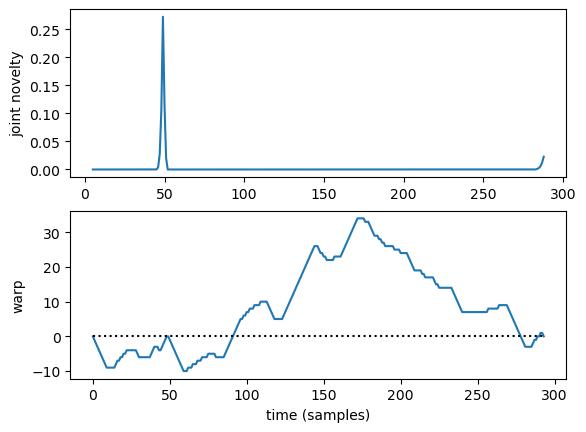

In [151]:
# Compute and plot joint novelty along with DTW pointwise warp, using parameters of the cell above:

kernel_size = 10 # <--- kernel size
kernel_sd = kernel_size/4 # <--- kernel's gaussian taper standard deviation

fig, axs = plt.subplots(2)
axs[0].plot(novelty(mean_dm,kernel_size,kernel_sd))
axs[0].set_ylabel('joint novelty')
axs[1].plot(warps_dtw(mean_dm,opm_1))
axs[1].plot( np.zeros(mean_dm.shape[0]) ,':k')
axs[1].set_ylabel('warp');
axs[1].set_xlabel('time (samples)');

if results_path:
    this_filename = results_path+'/3'
else:
    this_filename = ''
plt.savefig(this_filename+'.png')

In the figure above the top plot shows the joint novelty, where its peaks indicate alignment. The bottom plot shows the pointwise warp.